<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomalies Detection

> **Anomalies or outliers come in three types.**

1. **Point Anomalies** - an *individual data instance* considered as anomalous with respect to the rest of the data (e.g. purchase with large transaction value)
2. **Contextual Anomalies** - a data instance is anomalous in a *specific context*,  occur at a certain time or a certain region (e.g. large spike at the middle of the night)
3. **Collective Anomalies** - a collection of *related data instances* is anomalous with respect to the entire dataset, not individual values. Two variations:
  - Events in unexpected order ( ordered. e.g. breaking rhythm in ECG)
  - Unexpected value combinations, unordered (e.g. buying a large number of expensive items)


#### **Anomaly Detection Techniques**
> Anomaly detection can be approached in many ways depending on the nature of data and circumstances

- **Static Rules Approach** - indentify list of anomalies and write rules to detect those. It can be done using *pattern mining techniques*.

**Have Training Data:**
- The **standard classification methods** such as SVM or Random Forest might give our high accuracy in simple anomaly cases
- If the data points are autocorrelated with each other, **time series classification** or **Recurrent Neural networks** are used

**No Training Data:**
> unsupervised learning and semi-supervised learning can be used

 **Univariate Collective Outliers**
  - Time Series data: anomaly happen because value occur in unexpected order
    
  *Approach*
  - using **residuals** from regression, time series, RNN models
  - Markov chains and Hidden Markov chains: measure probability of a sequence of events happening and detect rare sequences

**Multivariate Collective Outliers (Unordered)**
> multivariate data but not ordered: high temperature but slow hearbeats although in a normal range
  *Approach*
  - **Clustering**
  - **Nearest neighbor techniques**

**Multivariate Collective Outliers 
(Ordered)**
> multivariate variables in normal range but fluctual quickly in short period of time

  *Approach*
  - **Combine Markov Chains and Clustering**  


**Other Approaches:**
- **Information Theory:** anomlies often have high information content due to irregularities
- **Dimension Reduction:** anomalies tend to create complex combinations

- **Graph Analysis:** Flow analysis might show anomalies between interaction (e.g insurance, stock markets)


### 1. Downloading Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d boltzmannbrain/nab

  0% 0.00/1.64M [00:00<?, ?B/s]
100% 1.64M/1.64M [00:00<00:00, 55.0MB/s]


In [ ]:
import os
from zipfile import ZipFile

In [ ]:
path = 'data/'
with ZipFile('nab.zip') as f:
  f.extractall(path=path)

Dataset Context
> The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data 

In [ ]:
import pandas as pd

In [ ]:
csv_file = '/content/data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv'
data = pd.read_csv(csv_file)
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


#### 1.2 Data Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

%matplotlib inline

In [ ]:
sns.set_palette(palette=sns.cubehelix_palette(start=.5, rot=-.5))
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1
plt.rc('figure', titlesize = 18)

In [ ]:
data.timestamp = pd.to_datetime(data.timestamp)

In [ ]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22695 non-null  datetime64[ns]
 1   value      22695 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB


In [ ]:
data.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


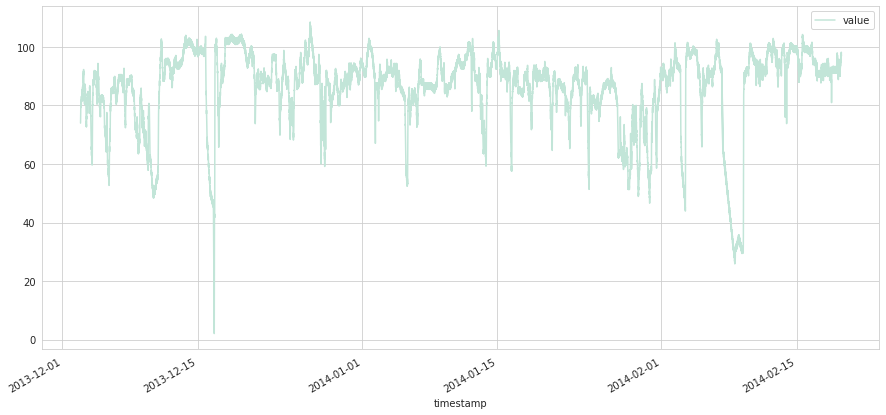

In [ ]:
data.plot(x = 'timestamp', y = 'value')

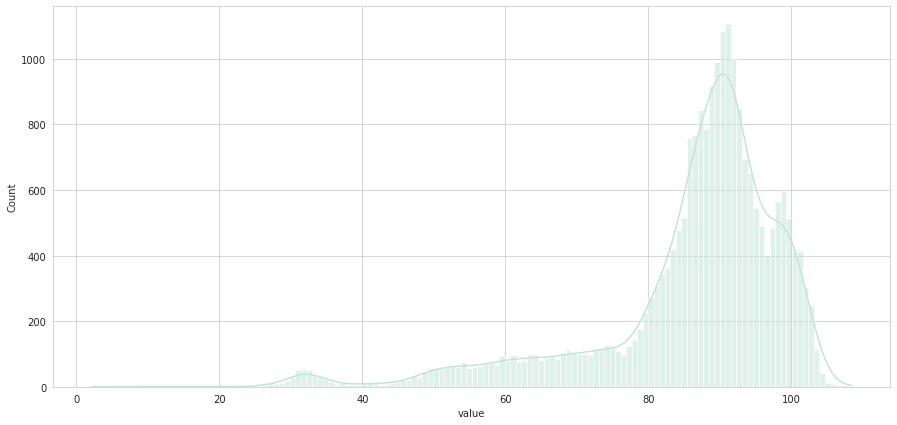

In [ ]:
sns.histplot(data.value, kde=True)

### 2. Data Preparation

define anomaly population which might be neccessary for some algorithms

In [ ]:
anomaly_fraction = 0.01

#### 2.1 Feature Engineering

##### 2.1.1 Adding useful features

In [ ]:
data = data.assign(year = data.timestamp.dt.year,
                  month = data.timestamp.dt.month,
                  day = data.timestamp.dt.day,
                  hour = data.timestamp.dt.hour,
                  days_in_month = data.timestamp.dt.daysinmonth,
                  day_of_year = data.timestamp.dt.dayofyear,
                  day_of_week = data.timestamp.dt.dayofweek,
                  week_of_year = data.timestamp.dt.weekofyear,
                  quarter = data.timestamp.dt.quarter)

data = data.assign(is_weekday = data.day_of_week.apply(lambda x: 0 if x > 5 else 1),
                   is_daylight = data.hour.apply(lambda x: 0 if x > 18 else 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
data.head(3)

,timestamp,value,year,month,day,hour,days_in_month,day_of_year,day_of_week,week_of_year,quarter,is_weekday,is_daylight
0,2013-12-02 21:15:00,73.967322,2013,12,2,21,31,336,0,49,4,1,0
1,2013-12-02 21:20:00,74.935882,2013,12,2,21,31,336,0,49,4,1,0
2,2013-12-02 21:25:00,76.124162,2013,12,2,21,31,336,0,49,4,1,0


##### 2.1.2 Encode cyclical features

In [ ]:
def encode_cyclical(time_series, max_val):
  sin = np.sin(time_series * 2 * np.pi / max_val)
  cos = np.cos(time_series * 2 * np.pi / max_val)
  return sin, cos

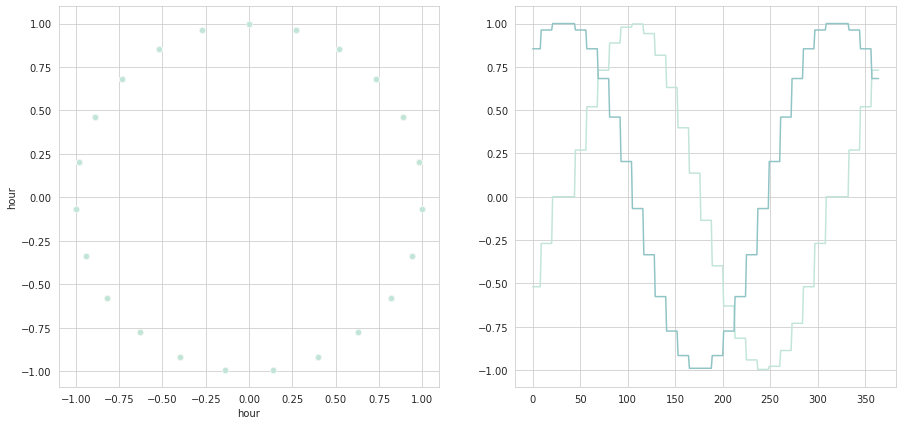

In [ ]:
hr_sin, hr_cos = encode_cyclical(data.hour, 23)

f, ax = plt.subplots(1, 2, figsize = (15, 7))
sns.scatterplot(x=hr_sin, y=hr_cos, ax=ax[0])
ax[1].plot(hr_sin[:365])
ax[1].plot(hr_cos[:365])

#### 2.2 Define columns

In [ ]:
target_col = ['value']
numerical_cols = data.select_dtypes(np.number).columns.drop(target_col)

#### 2.3 Standardize data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[numerical_cols]))

#### 2.3 Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
pca_data = pd.DataFrame(pca.fit_transform(scaled_data))

#### 2.4 Explore Data Analysis

Text(0.5, 1.0, 'Correlation Maxtrix')

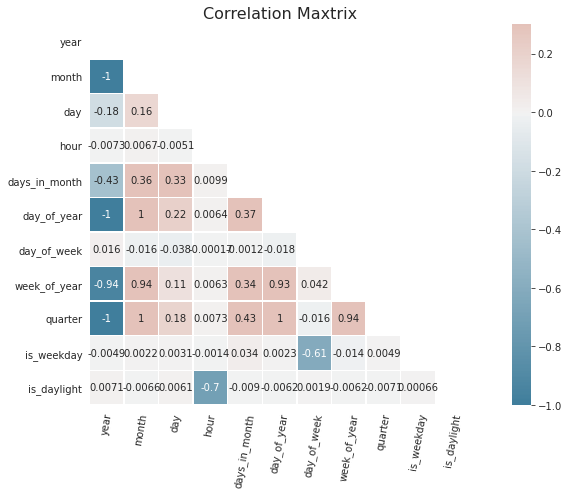

In [ ]:
corr_matrix = data[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, annot = True)
fig.set_xticklabels(fig.get_xticklabels(), rotation=80)
plt.title('Correlation Maxtrix', fontsize=16)

### 3. Models

#### 3.1 Clustering
> Use for collective anomalies (unordered)

Group data points together base on its features. Points that clustered far away from cluster centroid is consider as anomalies

##### KMeans Cluster

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_cluster = range(2, 18)
kmeans = [KMeans(n_clusters = n).fit(pca_data) for n in n_cluster]
scores = [kmean.score(pca_data) for kmean in kmeans]
inertias = [kmean.inertia_ for kmean in kmeans]

Text(0, 0.5, 'inertia')

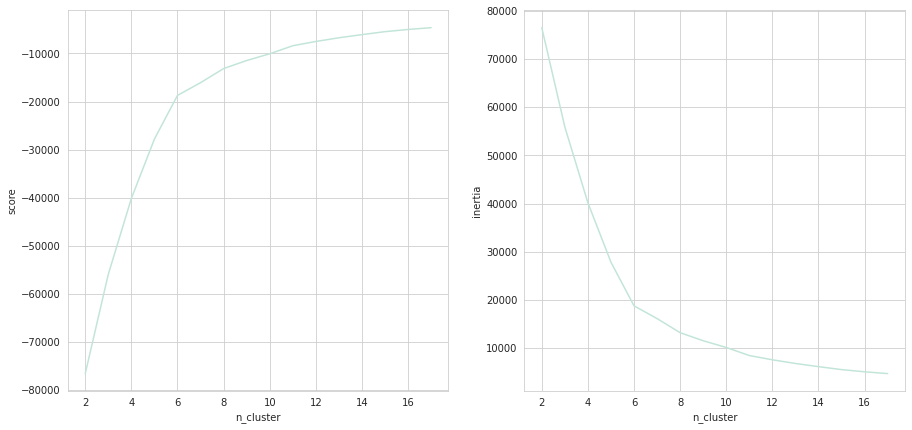

In [ ]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(x = n_cluster, y = scores, ax=ax[0])
ax[0].set_xlabel('n_cluster')
ax[0].set_ylabel('score')

sns.lineplot(x = n_cluster, y = inertias, ax=ax[1])
ax[1].set_xlabel('n_cluster')
ax[1].set_ylabel('inertia')

In [ ]:
kmean = KMeans(n_clusters=6).fit(pca_data)
cluster = kmean.predict(pca_data)

In [ ]:
kmean.cluster_centers_

array([[-1.71990373, -0.60969212, -0.46241072],
       [ 2.92702946, -0.63505128, -0.44345802],
       [-1.77524182,  0.0257733 ,  2.82063661],
       [-1.69908447,  2.3630827 , -0.47062092],
       [ 2.94287007,  2.33598394, -0.47113331],
       [ 3.01686781, -0.00787123,  2.83777932]])

In [ ]:
def getDistanceByPoint(data, model):
  distance = pd.Series(dtype='float64')
  for i in range(len(data)):
    Xa = np.array(data.loc[i])
    Xb = model.cluster_centers_[model.labels_[i]-1]
    distance.at[i] = np.linalg.norm(Xa-Xb)
  return distance

In [ ]:
distance = getDistanceByPoint(pca_data, kmean)

In [ ]:
n_anomaly = int(anomaly_fraction * len(distance))
anomaly_index = distance.nlargest(n_anomaly).index

In [ ]:
anomaly = pca_data.loc[anomaly_index]

In [ ]:
fig = px.scatter_3d(pca_data, x=0, y=1, z=2, color=cluster)
fig.add_trace(go.Scatter3d(x=kmean.cluster_centers_[:, 0], y=kmean.cluster_centers_[:, 1], z=kmean.cluster_centers_[:,2],
                           name='Cluster Centers', mode='markers+markers'))
fig.add_trace(go.Scatter3d(x=anomaly[0], y=anomaly[1], z=anomaly[2],
                           name='Ouliers', mode='markers+markers'))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show();

Text(0.5, 1.0, 'KMeans Clustering Result')

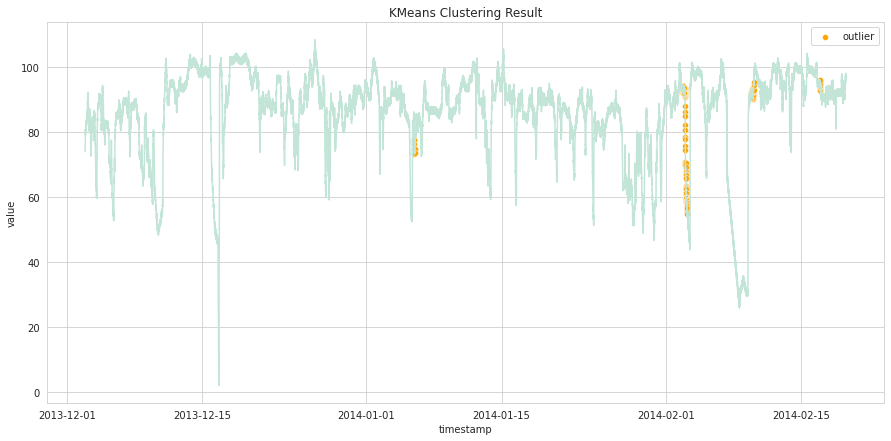

In [ ]:
fig, ax = plt.subplots(1)
sns.lineplot(data=data, x = 'timestamp', y = 'value', ax=ax)
sns.scatterplot(data=data.loc[anomaly_index], x='timestamp', y='value', color='orange', label='outlier')
plt.title('KMeans Clustering Result')

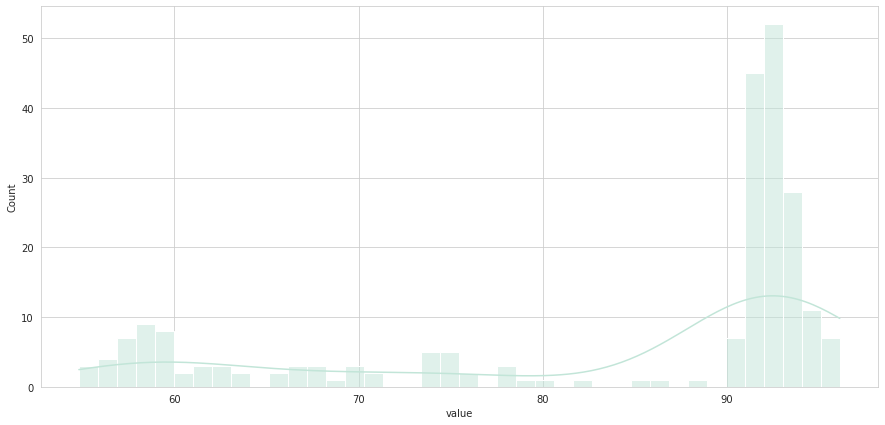

In [ ]:
sns.histplot(data.loc[anomaly_index].value, bins=40, kde=True)

#### 3.3 LocalOutlierFactor
> Unsupervised Outlier Detection using Local Outlier Factor (LOF)

Anomaly score (called as LOF) are defined by how isolated the data point is with respect surrounding data points
- Locality is given by k-nearest neighbors
- Comparing the local density of a sample to the local densities of its neighbors
- Points with substantially  lower density than their neighbors are consider outliers


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

Text(0.5, 1.04, 'Local Outlier Factor Anomaly Detection Result')

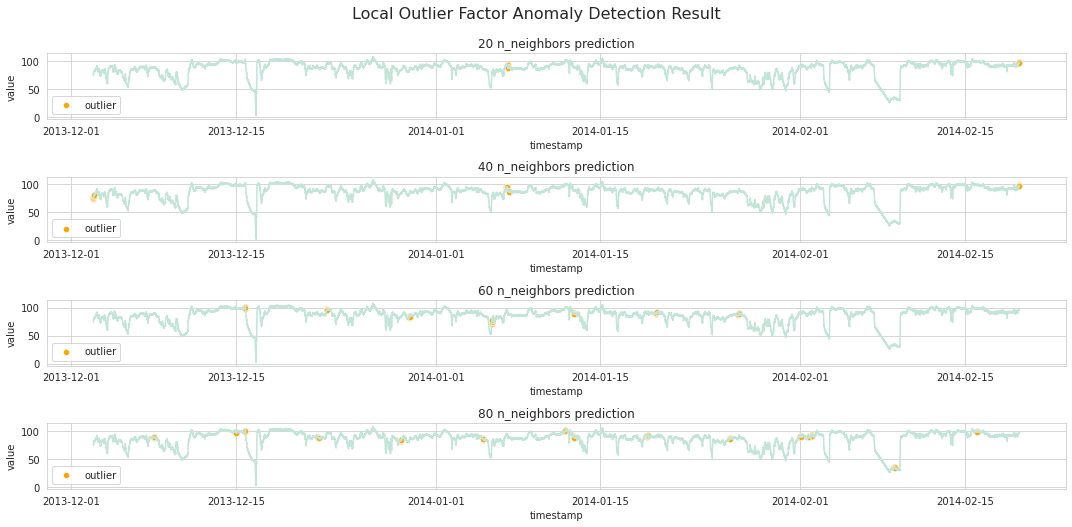

In [ ]:
n_neightbors = range(20, 100, 20)

for i, n_neighbor in enumerate(n_neightbors):
  plt.subplot(len(n_neightbors), 1, i+1)
  lof = LocalOutlierFactor(n_neighbor, p=2, contamination=anomaly_fraction)
  pred = lof.fit_predict(scaled_data)

  anomaly = data[pred == -1]
  sns.lineplot(data=data, x = 'timestamp', y = 'value')
  sns.scatterplot(data=anomaly, x='timestamp', y='value', color='orange', label='outlier')
  plt.title(f'{n_neighbor} n_neighbors prediction')

plt.tight_layout()
plt.suptitle('Local Outlier Factor Anomaly Detection Result', y=1.04)

#### 3.3 Isolation Forest
> Use for collective anomalies (unordered)

Isolation Forests are unseupervised model which built based on decision trees. Random feature is selected and branching accordding to a threshold

Finally, Anomalies scores are assigned based on the depth of tree to arrive the final node
>  -1 = anomalies  /  1 = normal

Disadvantages:
- Final anomaly score depends on the contamination parameter
- Model might suffers from a bias due to the way the branching takes place.



In [ ]:
from sklearn.ensemble import IsolationForest

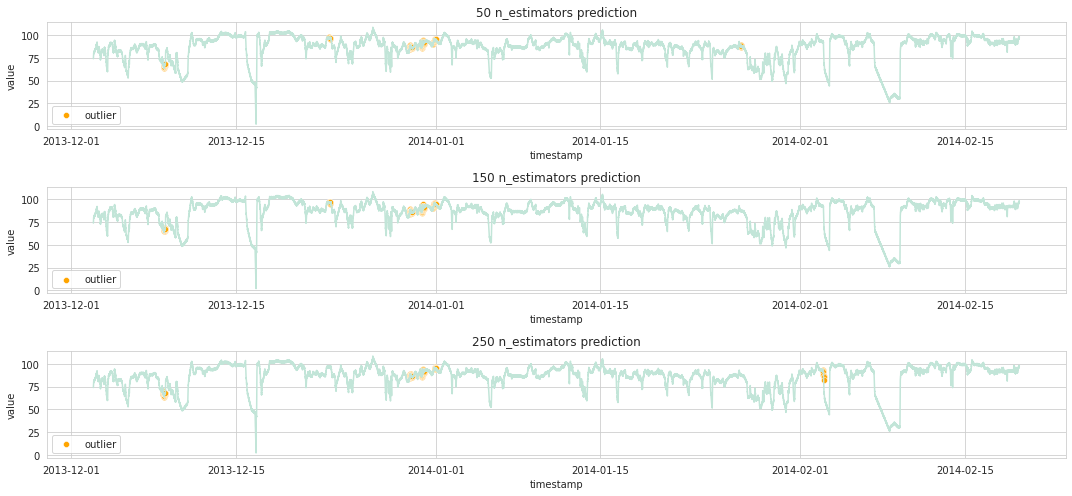

In [ ]:
n_estimators = range(50, 350, 100)
for i, n_estimator in enumerate(n_estimators):
  plt.subplot(len(n_estimators), 1, i+1)
  forest = IsolationForest(n_estimators=n_estimator, contamination=anomaly_fraction)
  pred = forest.fit_predict(scaled_data)
  anomaly = data[pred == -1]
  sns.lineplot(data=data, x = 'timestamp', y = 'value')
  sns.scatterplot(data=anomaly, x='timestamp', y='value', color='orange', label='outlier')
  plt.title(f'{n_estimator} n_estimators prediction')

plt.tight_layout()

#### 3.4 EllipticEnvelope
> gaussian distribution

In [ ]:
from sklearn.covariance import EllipticEnvelope

In [ ]:
envelope = EllipticEnvelope(contamination=anomaly_fraction)
X_train = data.value.values.reshape(-1, 1)
envelope.fit(X_train)

EllipticEnvelope(assume_centered=False, contamination=0.01, random_state=None,
                 store_precision=True, support_fraction=None)

In [ ]:
anomaly = data[envelope.predict(X_train) == -1]
normal = data[envelope.predict(X_train) != -1]

In [ ]:
envelope.score_samples(X_train)

array([-6.34992312, -5.62748662, -4.80074181, ..., -1.02507802,
       -1.32927421, -0.95482012])

Result Visualization

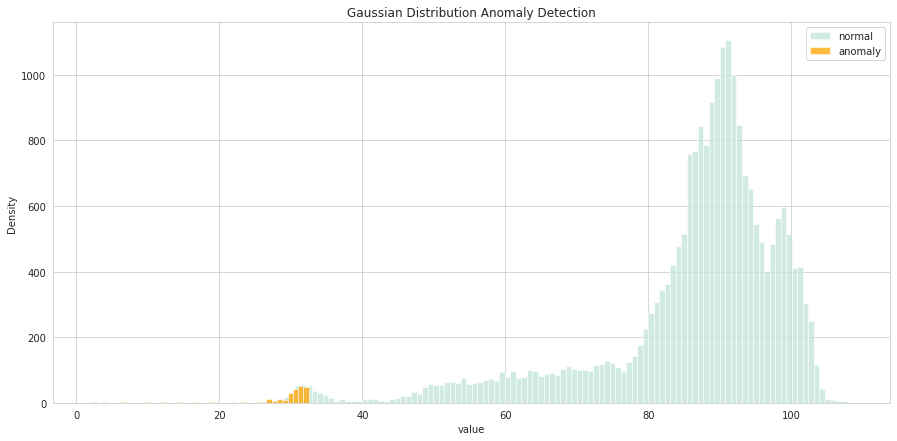

In [ ]:
plt.title('Gaussian Distribution Anomaly Detection')
sns.histplot(data.value, label='normal')
sns.histplot(anomaly.value, color='orange', label='anomaly')
plt.ylabel('Density')
plt.legend()

Text(0.5, 1.0, 'Gaussian Distribution Detection Result')

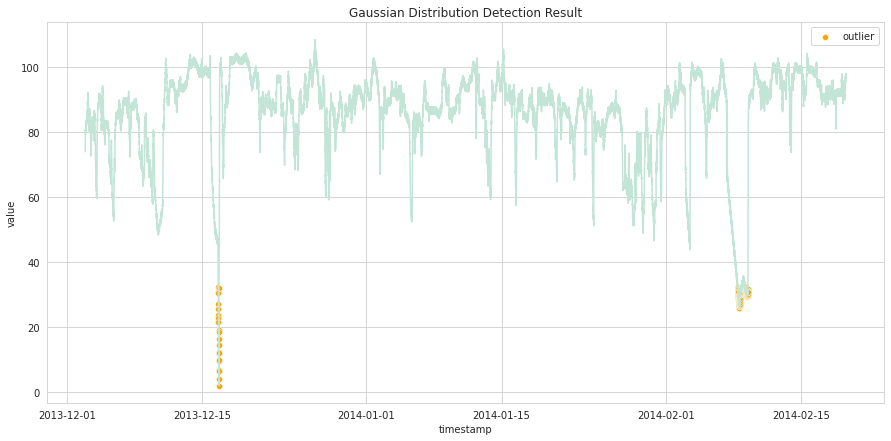

In [ ]:
ig, ax = plt.subplots(1)
sns.lineplot(data=data, x = 'timestamp', y = 'value', ax=ax)
sns.scatterplot(data=anomaly, x='timestamp', y='value', color='orange', label='outlier')
plt.title('Gaussian Distribution Detection Result')

#### 3.5 One-Class SVM

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
svm = OneClassSVM(nu=0.95 * anomaly_fraction)
pred = svm.fit_predict(scaled_data)
anomaly = data[pred == -1]

Text(0.5, 1.0, 'One-Class SVM Anomaly Detection Result')

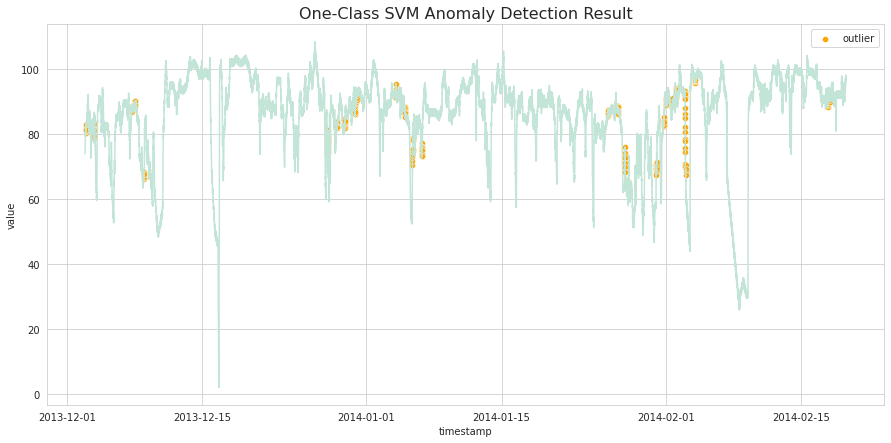

In [ ]:
sns.lineplot(data=data, x = 'timestamp', y = 'value')
sns.scatterplot(data=anomaly, x='timestamp', y='value', color='orange', label='outlier')
plt.title('One-Class SVM Anomaly Detection Result', fontsize=16)

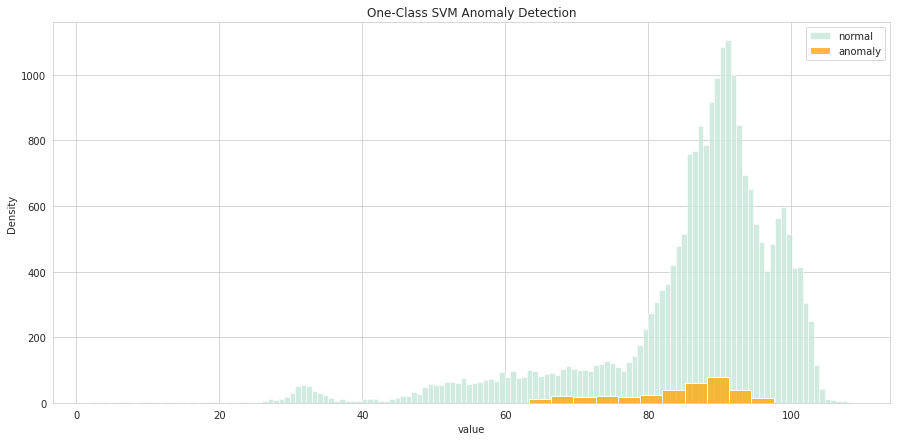

In [ ]:
plt.title('One-Class SVM Anomaly Detection')
sns.histplot(data.value, label='normal')
sns.histplot(anomaly.value, color='orange', label='anomaly')
plt.ylabel('Density')
plt.legend()

#### 3.6 LSTM - Recurrent Neural Network

As RNN model with LSTM predict base on previous sequence. Anomaly data can be detect if the next data point are distant by looking at size of prediction and size of sequence

##### 3.6.1 Data Preparation

In [ ]:
feature_cols = numerical_cols.tolist()
target_col = ['value']
dataset = data[feature_cols + target_col]

In [ ]:
hour_sin, hour_cos = encode_cyclical(data.hour, 23)
dataset.insert(0, 'hour_sin', hour_sin)
dataset.insert(0, 'hour_cos', hour_cos)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

Prepare the dataset which use previous 100 values as input

In [ ]:
def create_dataset(data, timestep=1):
  X, y = [], []
  for i in range(timestep, len(data)):
    feature = data[i - timestep:i]
    X.append(feature)
    targ = data[i]
    y.append(targ)
  return np.array(X), np.array(y)

Reshape input into (n_samples, n_timesteps, n_features)

In [ ]:
timestep = 200
train_size = int(0.85 * (len(dataset)))
train_size -= timestep
train, test = scaled_data[:train_size], scaled_data[train_size:]
X_train, train_result = create_dataset(train, timestep)
X_test, test_result = create_dataset(test, timestep)
y_train = train_result[:, -1].copy()
y_test = test_result[:, -1].copy()

X_train.shape, y_train.shape

((18890, 200, 14), (18890,))

##### 3.6.2 Building LSTM - RNN model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential([
                          layers.LSTM(128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
                          layers.Dropout(0.2),
                          layers.LSTM(50, return_sequences=True),
                          layers.Dropout(0.2),
                          layers.LSTM(50, return_sequences=False),
                          layers.Dense(64),
                          layers.Dense(1)
])

In [ ]:
lr = 1e-4
loss = keras.losses.MeanSquaredError()
metric = ['mae']
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
epochs = 20
batch_size = 250

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/20
76/76 [==============================] - 11s 142ms/step - loss: 0.0012 - mae: 0.0252 - val_loss: 0.0027 - val_mae: 0.0325
Epoch 2/20
76/76 [==============================] - 11s 140ms/step - loss: 0.0012 - mae: 0.0247 - val_loss: 0.0022 - val_mae: 0.0295
Epoch 3/20
76/76 [==============================] - 11s 140ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 0.0022 - val_mae: 0.0296
Epoch 4/20
76/76 [==============================] - 11s 140ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 0.0024 - val_mae: 0.0303
Epoch 5/20
76/76 [==============================] - 11s 140ms/step - loss: 0.0011 - mae: 0.0235 - val_loss: 0.0024 - val_mae: 0.0309
Epoch 6/20
76/76 [==============================] - 11s 140ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0025 - val_mae: 0.0313
Epoch 7/20
76/76 [==============================] - 11s 140ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 0.0024 - val_mae: 0.0324
Epoch 8/20
76/76 [==============================] - 11s 141ms/step - 

##### 3.6.3 Model Evaluation

In [ ]:
def visualize_performance(history, metric):
  plt.title(f'Model {metric}')
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train_' + metric, 'val_' + metric])

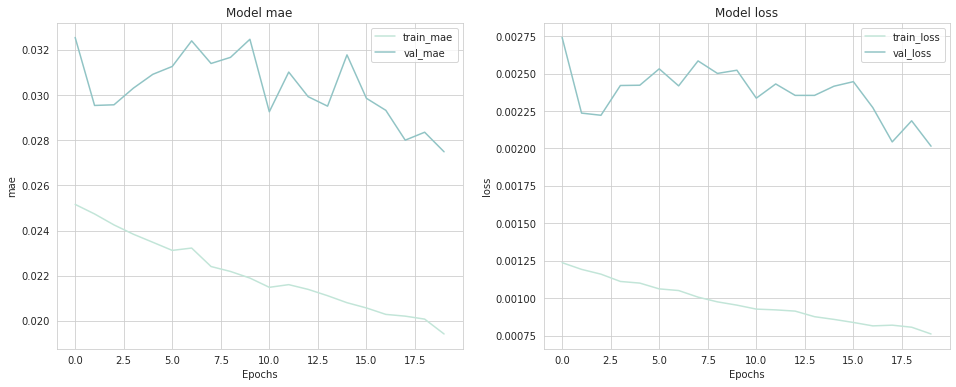

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
visualize_performance(history, 'mae')

plt.subplot(1, 2, 2)
visualize_performance(history, 'loss')


##### 3.6.4 Result Visualization

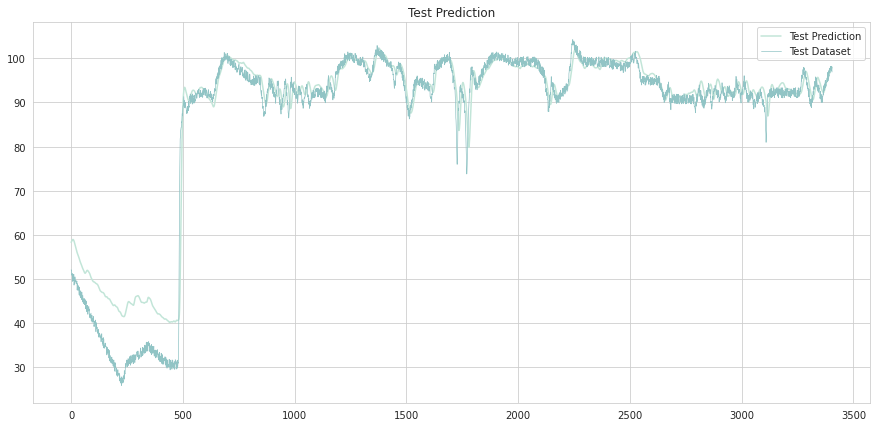

In [ ]:
y = scaler.inverse_transform(test_result)[:, -1]

pred_result = test_result.copy()
pred_result[:, -1] = model.predict(X_test).reshape(-1)
pred = scaler.inverse_transform(pred_result)[:, -1]

f, ax = plt.subplots(1)
ax.set_title('Test Prediction')
ax.plot(pred, label = 'Test Prediction')
ax.plot(y, label = 'Test Dataset', linewidth=0.7)
ax.legend()

In [ ]:
train_pred, test_pred = model.predict(X_train).reshape(-1), model.predict(X_test).reshape(-1)

#### **3.6.5 Anomaly Detection**


Approach 1

> **Prediction Different:** compute the different between actual data and prediction result. n largest differences points are anomalies

In [ ]:
diff = []
ratio = []
y = np.append(y_train, y_test)
prediction = np.append(train_pred, test_pred)
for i in range(len(y)):
    ratio.append((y[i] / prediction[i]) -1)
    diff.append(abs(y[i] - prediction[i]))

In [ ]:
anomaly

,timestamp,value,year,month,day,hour,days_in_month,day_of_year,day_of_week,week_of_year,quarter,is_weekday,is_daylight
269,2013-12-03 19:40:00,85.671723,2013,12,3,19,31,337,1,49,4,1,0
270,2013-12-03 19:45:00,85.569661,2013,12,3,19,31,337,1,49,4,1,0
271,2013-12-03 19:50:00,86.339368,2013,12,3,19,31,337,1,49,4,1,0
272,2013-12-03 19:55:00,85.824103,2013,12,3,19,31,337,1,49,4,1,0
274,2013-12-03 20:05:00,86.735574,2013,12,3,20,31,337,1,49,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21081,2014-02-14 01:00:00,98.039444,2014,2,14,1,28,45,4,7,1,1,1
22397,2014-02-18 14:40:00,83.731850,2014,2,18,14,28,49,1,8,1,1,1
22398,2014-02-18 14:45:00,82.953906,2014,2,18,14,28,49,1,8,1,1,1
22399,2014-02-18 14:50:00,80.969539,2014,2,18,14,28,49,1,8,1,1,1


In [ ]:
n_anomaly = int(anomaly_fraction * len(diff))
threshold = pd.Series(diff).nlargest(n_anomaly).min()

anomaly_index = np.empty_like(dataset.value.values, dtype=bool) * False
anomaly_index[timestep:train_size] = train_mae > threshold
anomaly_index[train_size+timestep:] = test_mae > threshold

anomaly = data[anomaly_index]

Text(0.5, 1.0, 'LSTM Model Anomaly Detection Result')

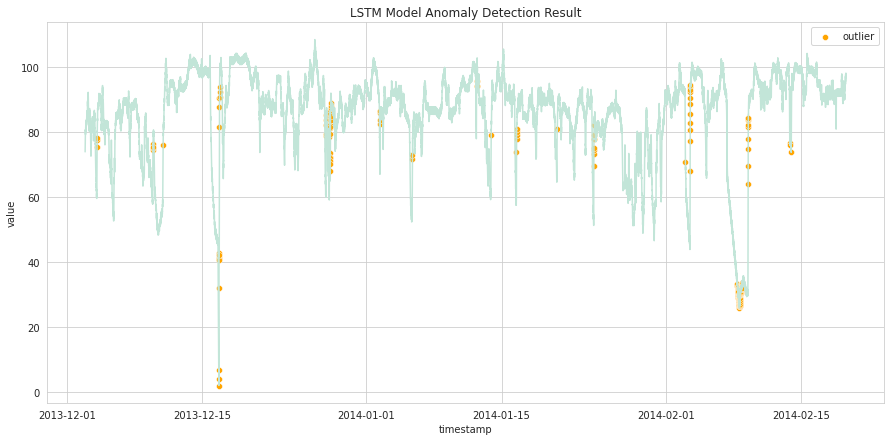

In [ ]:
sns.lineplot(data=data, x = 'timestamp', y = 'value')
sns.scatterplot(data=anomaly, x='timestamp', y='value', color='orange', label='outlier')
plt.title('LSTM Model Anomaly Detection Result')

Approach 2

> **Static threshold:** calculated as the overall mean + 2 std steps of the MAE on the entire trained data

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
test_mae = np.abs(y_test - test_pred)
train_mae = np.abs(y_train - train_pred)
mae = np.append(train_mae, test_mae)

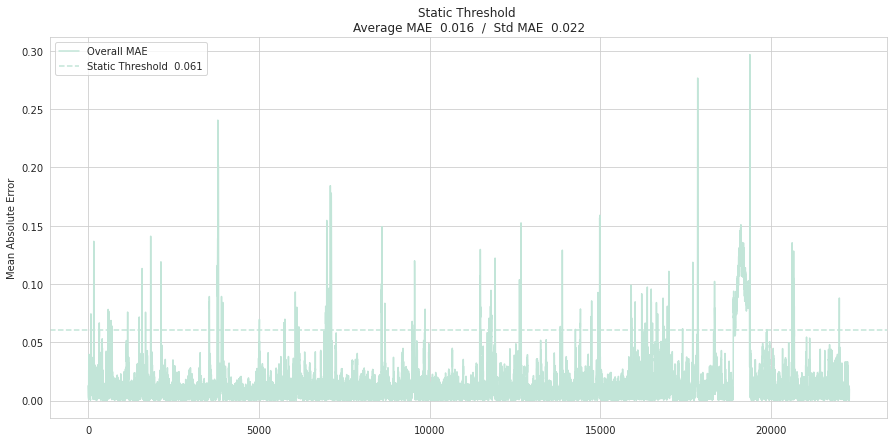

In [ ]:
std_mae = mae.std()
avg_mae = mae.mean()
threshold = avg_mae + (std_mae * 2)

f, ax = plt.subplots(1)
ax.plot(mae, label='Overall MAE')
ax.axhline(threshold, ls='--', label=f'Static Threshold {threshold: .3f}')
ax.set_title(f'Static Threshold \nAverage MAE {avg_mae: .3f}  /  Std MAE {std_mae: .3f}')
ax.set_ylabel('Mean Absolute Error')
ax.legend()

In [ ]:
anomaly_index = np.empty_like(dataset.value.values, dtype=bool) * False
anomaly_index[timestep:train_size] = train_mae > threshold
anomaly_index[train_size+timestep:] = test_mae > threshold

anomaly = data[anomaly_index]

Text(0.5, 1.0, 'Static Threshold on LSTM Model Prediction')

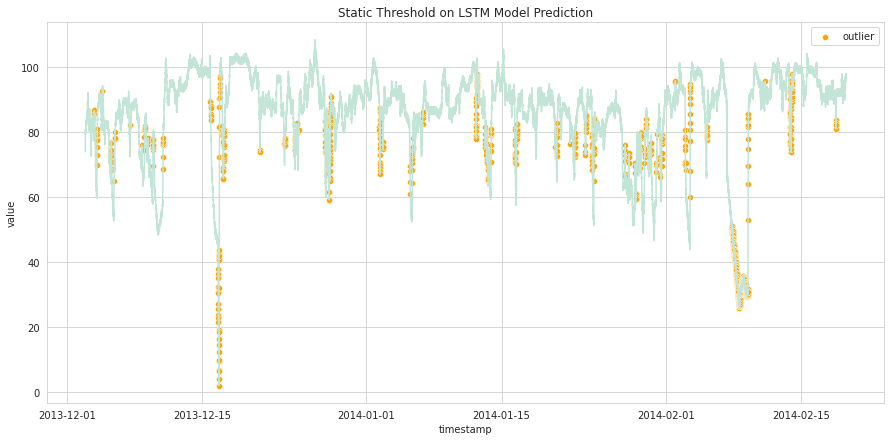

In [ ]:
sns.lineplot(data=data, x = 'timestamp', y = 'value')
sns.scatterplot(data=anomaly, x='timestamp', y='value', color='orange', label='outlier')
plt.title('Static Threshold on LSTM Model Prediction')

Approach 3



> **Dynamic threshold:** using rolling mean or exponential mean as threshold

`alpha` parameter control the smoothing of the series

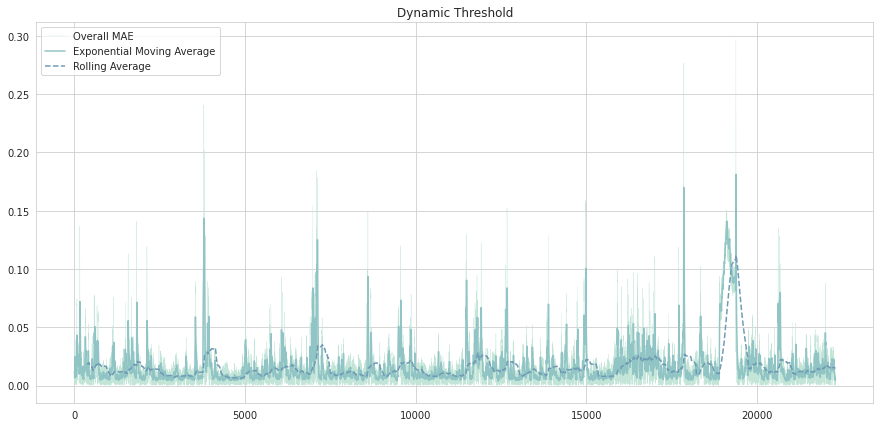

In [ ]:
window = 365
alpha = .1
mae = pd.DataFrame(mae, columns=['mae'])
rm_mae = mae.rolling(window).mean()
ewm_mae = mae.ewm(alpha = alpha).mean()

f, ax = plt.subplots(1)
ax.plot(mae, label='Overall MAE', linewidth=.3)
ax.plot(ewm_mae.mae, label='Exponential Moving Average')
ax.plot(rm_mae.mae, ls='--', label='Rolling Average')
plt.title(f'Dynamic Threshold')
ax.legend()

### References:

In [ ]:
## Inspration:
# https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection

In [ ]:
# https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/
# https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/
# https://blog.taboola.com/anomaly-detection-using-lstm-autoencoder/